<img src="OC.png" width="50" height="50" align="left">    

***

<center> <font size="6"> <span style='color:Blue'> P6: Classifiez automatiquement des biens de consommation </span></font> </center>  

***

<font size="3"> <span style="font-size: 1.5em" > **Partie 1 - 2/3: Etude de faisabilité via les données images** </span> </font>  

**Contexte**  
**Place de marché** est une entreprise qui propose souhaite lancer une marketplace e-commerce.
<img src="PlaceDeMarche.png" width="400" height="200">
**Mission**     
* **Partie 1:**  
Réaliser une première **étude de faisabilité** de regroupement des produits de même catégorie via les descriptions ;
    * **1. textuelle** 
    * **2. image** 
    * **3. textuelle et image**
de ces produits.
* **Partie 2:**  
Réaliser une **classification supervisée** à partir des images;
    * **1. avec data augmentation**  
    * **2. avec des techniques recentes**

Dans ce notebook, nous analyserons le jeu de données en réalisant :
* Un prétraitement des données **image**;
* Une extraction de features ;
* Une réduction en 2 dimensions, afin de projeter les produits sur un graphique 2D, sous la forme de points dont la couleur correspondra à la catégorie réelle ;
* Une analyse du graphique afin d’en déduire ou pas, à l’aide des images, la faisabilité de regrouper automatiquement des produits de même catégorie ;
* Une réalisation d’une mesure pour confirmer ton analyse visuelle, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters.

# Importation des données et des librairies Python pour DS

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn import cluster, metrics
from glob import glob
from matplotlib.image import imread
from sklearn import manifold, decomposition
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import time
import cv2

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
data_categories = pd.read_csv('./data/Traited/data_categories.csv')
data = data_categories.loc[:, ['uniq_id',
                               'image',
                               'categorie_l1_',
                               'categorie_n1_']]

In [3]:
data_categories_image = data
data = data_categories_image.copy()
data.head()

,uniq_id,image,categorie_l1_,categorie_n1_
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4


In [4]:
path = './data/Images/'

In [5]:
data = data.rename(columns={"image": "image_path",
                            "categorie_l1_": "label_name",
                            "categorie_n1_": "label"})
data.head()

,uniq_id,image_path,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4


In [6]:
data["image_path"] = data["image_path"].apply(lambda x : path + x)

In [7]:
data.head()

,uniq_id,image_path,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7,./data/Images/55b85ea15a1536d46b7190ad6fff8ce7...,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,./data/Images/7b72c92c2f6c40268628ec5f14c6d590...,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,./data/Images/64d5d4a258243731dc7bbb1eef49ad74...,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,./data/Images/d4684dcdc759dd9cdf41504698d737d8...,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,./data/Images/6325b6870c54cd47be6ebfbffa620ec7...,Home Furnishing,4


In [8]:
data.groupby("label").count()

,uniq_id,image_path,label_name
label,,,
0,150,150,150
1,150,150,150
2,150,150,150
3,150,150,150
4,150,150,150
5,150,150,150
6,150,150,150


In [9]:
set(data.label_name)

{'Baby Care',
 'Beauty and Personal Care',
 'Computers',
 'Home Decor & Festive Needs',
 'Home Furnishing',
 'Kitchen & Dining',
 'Watches'}

In [10]:
data['label_name'] = data['label_name'].astype('category')
list_labels = list(data['label_name'].cat.categories)
list_labels

['Baby Care',
 'Beauty and Personal Care',
 'Computers',
 'Home Decor & Festive Needs',
 'Home Furnishing',
 'Kitchen & Dining',
 'Watches']

In [113]:
# revoie la liste des images dans la catégorie name
def list_fct(name) :
    list_image_name = list(data.loc[data["label_name"]==name, "image_path"])
    return list_image_name

In [12]:
name = 'Baby Care'
filename = np.random.choice(list_fct(name), 1)[0]
filename

'./data/Images/8c62cbbd23958ae380fea906f6b5a994.jpg'

Baby Care


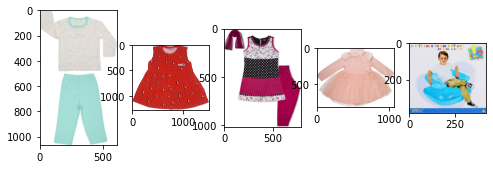

Beauty and Personal Care


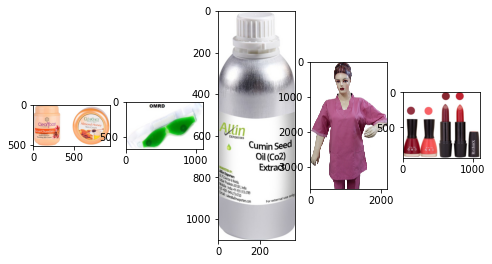

Computers


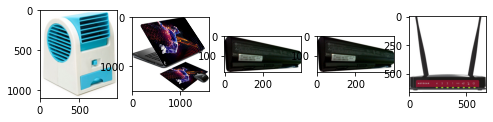

Home Decor & Festive Needs


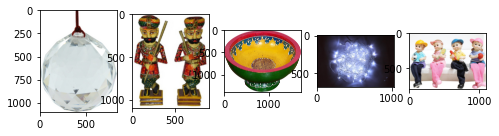

Home Furnishing


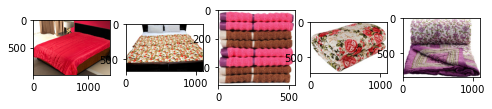

Kitchen & Dining


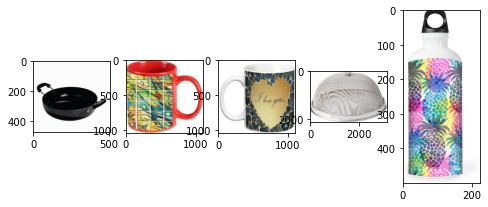

Watches


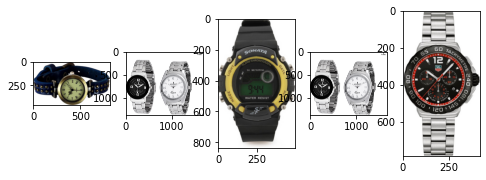

In [13]:
for name in list_labels :
    plt.figure(figsize=(8, 8))
    print(name)
    # print("-------")
    for i in range(5):
        plt.subplot(150 + 1 + i)
        filename = np.random.choice(list_fct(name), 1)[0]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

In [14]:
# data.to_csv('./data/Traited/data_categories_image.csv', index=False)

In [2]:
data = pd.read_csv('./data/Traited/data_categories_image.csv')
data.head()

,uniq_id,image_path,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7,./data/Images/55b85ea15a1536d46b7190ad6fff8ce7...,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,./data/Images/7b72c92c2f6c40268628ec5f14c6d590...,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,./data/Images/64d5d4a258243731dc7bbb1eef49ad74...,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,./data/Images/d4684dcdc759dd9cdf41504698d737d8...,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,./data/Images/6325b6870c54cd47be6ebfbffa620ec7...,Home Furnishing,4


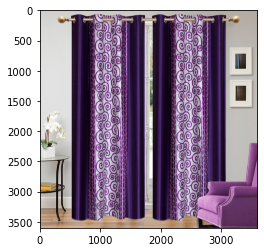

In [3]:
image_test_path = data.image_path[0] #626
image_test = imread(image_test_path)
plt.imshow(image_test)
plt.show()

# Algorithme SIFT : étude de faisabilité

## Détermination et affichage des descripteurs SIFT

* L'image_test contient 339 descripteurs sur l'image redimensionnée
* Chaque descripteur est un vecteur de longueur 128

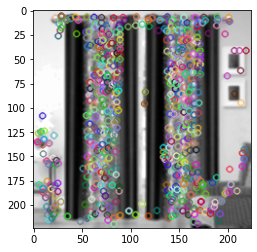

Descripteurs :  (619, 128)

[[ 0.  0. 31. ... 15. 29. 30.]
 [ 0.  1.  3. ...  0.  0.  0.]
 [20.  1.  0. ...  0.  0.  0.]
 ...
 [ 1.  0.  2. ...  0.  0.  7.]
 [38.  0.  0. ...  0.  0.  7.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [8]:
# Définir la nouvelle taille des images
new_width = 224
new_height = 224

sift = cv2.SIFT_create()
image_ = cv2.imread(image_test_path,0) # convert in gray
resized_img = cv2.resize(image_, (new_width, new_height))  # Redimensionner l'image
blur_img = cv2.GaussianBlur(resized_img, (5, 5), 0) # filtering noise
image = cv2.equalizeHist(blur_img)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

## Pré-traitement des images via SIFT

## Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [39]:
list_photos = data.image_path[0:5]
list_photos

0    ./data/Images/55b85ea15a1536d46b7190ad6fff8ce7...
1    ./data/Images/7b72c92c2f6c40268628ec5f14c6d590...
2    ./data/Images/64d5d4a258243731dc7bbb1eef49ad74...
3    ./data/Images/d4684dcdc759dd9cdf41504698d737d8...
4    ./data/Images/6325b6870c54cd47be6ebfbffa620ec7...
Name: image_path, dtype: object

In [9]:

# Définir la nouvelle taille des images
new_width = 224
new_height = 224

# identification of key points and associated descriptors
sift_keypoints = []
temps1=time.time()
sift = cv2.SIFT_create()
list_photos = data.image_path

for image_num in tqdm(range(len(list_photos))) :
    # if image_num%100 == 0 : print(image_num)
    image_ = cv2.imread(list_photos[image_num],0) # convert in gray
    resized_img = cv2.resize(image_, (new_width, new_height))  # Redimensionner l'image
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    blur_img = cv2.GaussianBlur(resized_img, (5, 5), 0) # filtering noise
    res = cv2.equalizeHist(blur_img)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

100%|██████████| 1050/1050 [00:44<00:00, 23.81it/s]
C:\Users\rimla\AppData\Local\Temp\ipykernel_34308\801871712.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)



Nombre de descripteurs :  (368797, 128)
temps de traitement SIFT descriptor :            44.20 secondes


## Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [10]:
# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  607
Création de 607 clusters de descripteurs ...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


temps de traitement kmeans :             8.23 secondes


## Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image
* Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [11]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(tqdm(sift_keypoints_by_img)) :
    # if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

100%|██████████| 1050/1050 [03:01<00:00,  5.78it/s]

temps de création histogrammes :           181.56 secondes


In [20]:
im_sift_features = pd.DataFrame(im_features, index=data.uniq_id)
im_sift_features.to_csv('./data/Traited/df_im_sift.csv', index=True)
im_sift_features

,0,1,2,3,4,5,6,7,8,9,...,597,598,599,600,601,602,603,604,605,606
uniq_id,,,,,,,,,,,,,,,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,0.001616,0.000000,0.003231,0.008078,0.004847,0.000000,0.000000,0.003231,0.000000,0.000000,...,0.001616,0.000000,0.000000,0.001616,0.003231,0.000000,0.000000,0.001616,0.000000,0.000000
7b72c92c2f6c40268628ec5f14c6d590,0.000000,0.005034,0.001678,0.000000,0.000000,0.000000,0.000000,0.000000,0.001678,0.001678,...,0.001678,0.003356,0.001678,0.000000,0.000000,0.001678,0.001678,0.001678,0.000000,0.001678
64d5d4a258243731dc7bbb1eef49ad74,0.000000,0.000000,0.000000,0.000000,0.001513,0.000000,0.000000,0.003026,0.001513,0.000000,...,0.000000,0.000000,0.001513,0.000000,0.066566,0.000000,0.000000,0.000000,0.003026,0.000000
d4684dcdc759dd9cdf41504698d737d8,0.001214,0.003641,0.006068,0.000000,0.000000,0.001214,0.000000,0.000000,0.000000,0.003641,...,0.001214,0.000000,0.003641,0.000000,0.000000,0.001214,0.000000,0.004854,0.000000,0.002427
6325b6870c54cd47be6ebfbffa620ec7,0.001233,0.011097,0.004932,0.002466,0.000000,0.000000,0.001233,0.002466,0.001233,0.006165,...,0.001233,0.001233,0.000000,0.001233,0.000000,0.001233,0.000000,0.001233,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958f54f4c46b53c8a0a9b8167d9140bc,0.000000,0.007614,0.002538,0.000000,0.002538,0.000000,0.000000,0.000000,0.005076,0.007614,...,0.002538,0.005076,0.000000,0.005076,0.002538,0.000000,0.000000,0.002538,0.000000,0.000000
fd6cbcc22efb6b761bd564c28928483c,0.000000,0.004878,0.000000,0.000000,0.000000,0.000000,0.000000,0.004878,0.004878,0.000000,...,0.000000,0.004878,0.004878,0.014634,0.000000,0.000000,0.009756,0.000000,0.000000,0.004878
5912e037d12774bb73a2048f35a00009,0.000000,0.000000,0.002155,0.000000,0.017241,0.000000,0.002155,0.002155,0.000000,0.000000,...,0.002155,0.000000,0.000000,0.006466,0.008621,0.000000,0.000000,0.004310,0.002155,0.006466


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (97%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

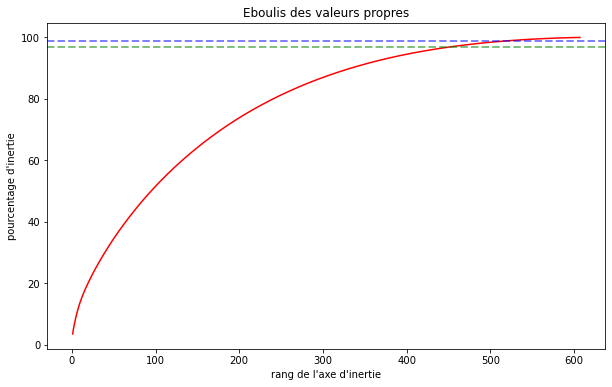

In [14]:
im_features_std = StandardScaler().fit_transform(im_features)
pca_1 = decomposition.PCA()
pca_1.fit(im_features_std)
scree = pca_1.explained_variance_ratio_*100
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red")
plt.axhline(y=99, xmin=0, xmax=(len(scree))+1, linewidth=2, color = 'b', ls='--', alpha=0.5)
plt.axhline(y=97, xmin=0, xmax=(len(scree))+1, linewidth=2, color = 'g', ls='--', alpha=0.5)
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [15]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.97)
feat_pca= pca.fit_transform(im_features_std)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 607)
Dimensions dataset après réduction PCA :  (1050, 454)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [26]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]
print(df_tsne.shape)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images

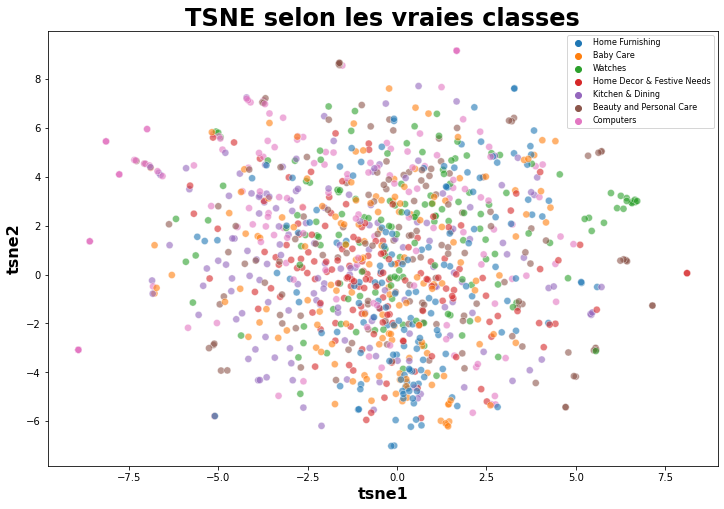

In [27]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 24, pad = 5, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 16, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 16, fontweight = 'bold')
plt.legend(prop={'size': 8}) 

plt.show()

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [24]:
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.05 très faible

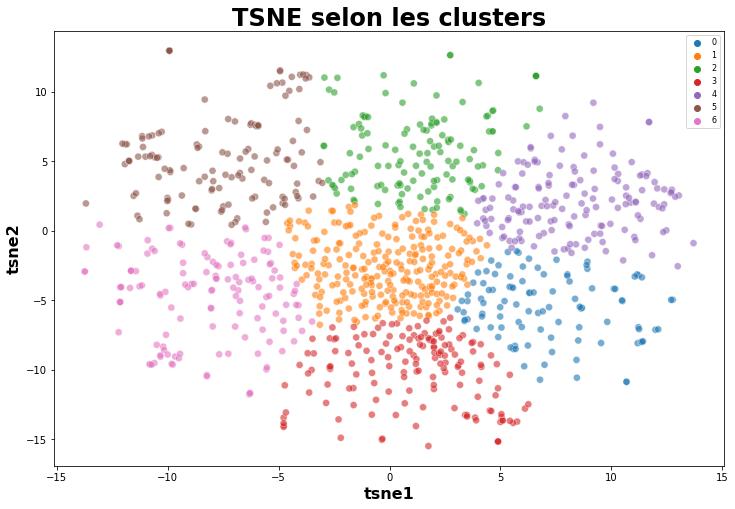

ARI :  0.04045726914539908


In [25]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 24, pad = 5, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 16, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 16, fontweight = 'bold')
plt.legend(prop={'size': 8}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

La classification selon l'algorithme SIFT n'est pas très faisable ?! ARI = 0.05

# Algorithme CNN Transfer learning : étude de faisabilité

## Création du modèle pré-entraîné

Ces deux lignes de code créent un modèle de réseau de neurones à convolution (CNN) basé sur l'architecture VGG16 pré-entraînée.

La première ligne crée une instance du modèle VGG16 en utilisant la méthode VGG16() de Keras. VGG16 est un modèle CNN très populaire qui a été pré-entraîné sur un grand ensemble de données d'images pour résoudre la classification d'image. Il est composé de 13 couches de convolution et 3 couches entièrement connectées.

La seconde ligne crée un nouveau modèle en utilisant la première couche jusqu'à l'avant-dernière couche du modèle VGG16 pré-entraîné. Cela signifie que la sortie de la dernière couche de la VGG16, qui est une couche entièrement connectée avec 1000 neurones correspondant aux classes d'objets, est supprimée. La sortie de ce nouveau modèle sera la sortie de la couche avant-dernière, qui est une représentation vectorielle de l'image.

Ainsi, ce modèle peut être utilisé pour extraire des caractéristiques de haut niveau à partir d'images, qui peuvent ensuite être utilisées pour résoudre diverses tâches de vision par ordinateur telles que la classification d'images, la détection d'objets, etc.

In [29]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Création des features des images

In [30]:
from tqdm import tqdm
list_photos = data.image_path
images_features = []

for image_num in tqdm(range(len(list_photos))) :
    image_ = load_img(list_photos[image_num], target_size=(224, 224))
    image = img_to_array(image_) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

 64%|██████▍   | 677/1050 [03:24<01:50,  3.36it/s]C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1050/1050 [05:18<00:00,  3.29it/s]


(1050, 4096)

In [32]:
vgg16_features = pd.DataFrame(images_features, index=data.uniq_id)
vgg16_features.to_csv('./data/Traited/df_vgg16_.csv', index=True)
vgg16_features

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
uniq_id,,,,,,,,,,,,,,,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,3.398614,0.859572,0.000000,1.106560,2.266122,2.927241,2.446448,0.000000,0.000000,0.000000,...,0.485876,0.0,0.000000,0.472938,0.875756,0.783684,0.000000,0.000000,0.851055,0.000000
7b72c92c2f6c40268628ec5f14c6d590,0.000000,0.000000,0.000000,1.172009,0.000000,0.000000,0.000000,0.000000,0.000000,6.499799,...,1.169696,0.0,0.000000,0.000000,0.000000,3.152507,0.000000,0.000000,0.000000,0.000000
64d5d4a258243731dc7bbb1eef49ad74,0.000000,0.000000,0.000000,4.457807,0.000000,0.000000,0.000000,0.000000,0.000000,2.820566,...,0.000000,0.0,0.000000,0.000000,0.000000,5.270284,0.000000,1.297100,0.000000,0.000000
d4684dcdc759dd9cdf41504698d737d8,0.000000,0.070991,0.000000,2.046283,0.000000,0.000000,0.000000,0.000000,0.000000,0.894023,...,0.000000,0.0,0.000000,0.000000,0.000000,3.977747,0.000000,0.000000,0.000000,0.000000
6325b6870c54cd47be6ebfbffa620ec7,3.417152,0.000000,0.000000,0.000000,1.012359,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,9.195916,0.139736,0.000000,1.735950,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958f54f4c46b53c8a0a9b8167d9140bc,2.312268,2.432937,0.000000,1.860516,3.101232,2.369040,0.000000,0.000000,1.428848,1.286600,...,0.000000,0.0,0.058723,0.000000,0.000000,0.000000,0.859425,1.085387,0.000000,0.000000
fd6cbcc22efb6b761bd564c28928483c,1.217184,0.365275,0.330849,0.000000,2.140628,0.000000,0.000000,0.767264,0.000000,3.563397,...,0.000000,0.0,0.837411,0.839075,0.000000,1.042109,0.000000,1.560315,0.000000,0.998342
5912e037d12774bb73a2048f35a00009,2.196130,2.398275,2.623641,0.983882,0.366652,0.535506,3.730995,0.000000,0.000000,0.000000,...,1.230694,0.0,0.000000,0.000000,0.000000,0.193308,0.546066,2.159872,0.184722,0.000000


## Réduction dimension et analyse

###  Réduction de dimension PCA

In [33]:
print(images_features.shape)
features_std = StandardScaler().fit_transform(images_features)
pca = decomposition.PCA(n_components=0.99, svd_solver='full')
feat_pca= pca.fit_transform(features_std)
print(feat_pca.shape)

(1050, 4096)
(1050, 850)


### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [34]:
temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30,
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de T-SNE :            10.55 secondes


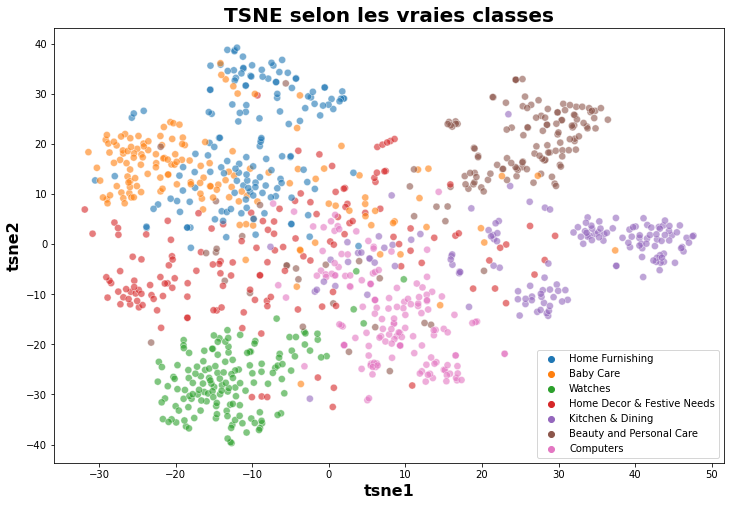

In [35]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7),
    s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 20, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 16, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 16, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Datam


### Création de clusters à partir du T-SNE et affichage des images selon clusters

* Attention : ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement

In [38]:
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

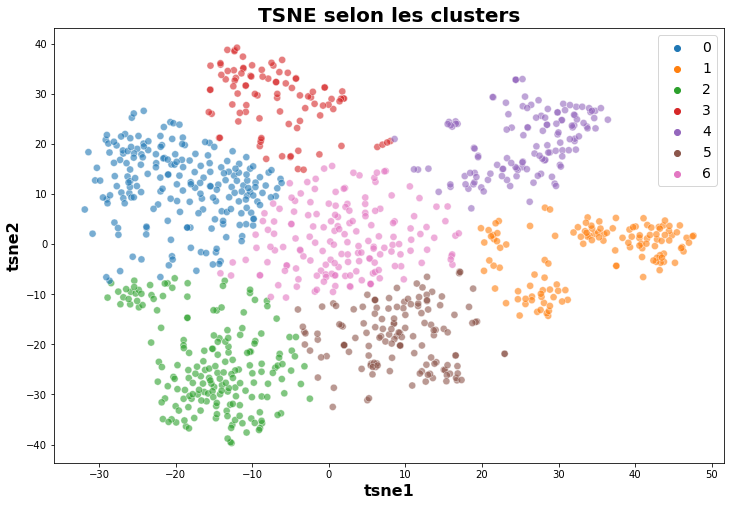

ARI :  0.46475436452929403


In [39]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize=20, fontweight='bold')
plt.xlabel('tsne1', fontsize=16, fontweight='bold')
plt.ylabel('tsne2', fontsize=16, fontweight='bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

# Conclusion

**Etude de faisabilité via les données visuelles:**  
**L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les produits selon leurs vraies catégorie.** Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les catégories des produits.  
**Plusieurs approches ont été testées, les meilleurs résultats sont obtenus par le modèle CNN Transfer Learning. On obtient un ARI de 0.44**.